# Imports all packages

In [44]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

## Scrapes the html from the webpage for the Postal Codes of Philadelphia

In [45]:
#Gets the url and scrapes the html 
url = 'http://ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=pa&StName=Pennsylvania&StFIPS=42&FIPS=42101'
req = urllib.request.urlopen(url)

soup = BeautifulSoup(req)

## Finds the table in the html

In [46]:
#Finds the table to scrape
table = soup.find('table')

#Provides the empty arrays for the html tags that are being grabbed and assigned to the headings
P = []
C = []

for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 3:
        P.append(cells[0].find(text=True))
        C.append(cells[1].find(text=True))

In [47]:
#Creates the dataframe and places the data in its respective columns
df_phil = pd.DataFrame(P, columns=['PostalCode'])
df_phil['City'] = C
df_phil.head()

,PostalCode,City
0,19019,Philadelphia
1,19101,Philadelphia
2,19102,Mid City East
3,19102,Middle City East
4,19102,Philadelphia


In [48]:
#A specialized function that joins the neighborhoods with the same postalcode
foo = lambda a: ','.join(a) 
df_phil = df_phil.groupby(['PostalCode']).agg({
                                'City': foo}).reset_index()

In [49]:
df_phil.head()

,PostalCode,City
0,19019,Philadelphia
1,19101,Philadelphia
2,19102,"Mid City East,Middle City East,Philadelphia"
3,19103,"Mid City West,Middle City West,Philadelphia"
4,19104,Philadelphia


## Reads csv file that contains the Latitude and Longitude of the Postal Codes

In [50]:
df_lonlat = pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=PA&q=philadelphia&timezone=America/New_York&use_labels_for_header=true', delimiter=';')
df_lonlat.head(20)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,19121,Philadelphia,PA,39.981062,-75.17450,-5,1,"39.981062, -75.1745"
1,19154,Philadelphia,PA,40.091460,-74.97719,-5,1,"40.09146, -74.97719"
2,19161,Philadelphia,PA,40.001811,-75.11787,-5,1,"40.001811, -75.11787"
3,19119,Philadelphia,PA,40.053511,-75.18858,-5,1,"40.053511, -75.18858"
4,19120,Philadelphia,PA,40.033944,-75.12118,-5,1,"40.033944, -75.12118"
5,19126,Philadelphia,PA,40.055411,-75.13793,-5,1,"40.055411, -75.13793"
6,19137,Philadelphia,PA,40.000262,-75.07404,-5,1,"40.000262, -75.07404"
7,19099,Philadelphia,PA,40.001811,-75.11787,-5,1,"40.001811, -75.11787"
8,19175,Philadelphia,PA,39.990562,-75.12957,-5,1,"39.990562, -75.12957"
9,19183,Philadelphia,PA,40.001811,-75.11787,-5,1,"40.001811, -75.11787"


## Drops unnecessary columns

In [51]:
df_lonlat.drop(['City', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)
df_lonlat.head()

,Zip,Latitude,Longitude
0,19121,39.981062,-75.17450
1,19154,40.091460,-74.97719
2,19161,40.001811,-75.11787
3,19119,40.053511,-75.18858
4,19120,40.033944,-75.12118


In [52]:
df_lonlat.rename(columns={'Zip':'PostalCode'}, inplace=True)

In [53]:
df_phil.PostalCode = df_phil.PostalCode.astype(int)

## Merges the Postal Code Dataframe with the latitude and longitude dataframe

In [54]:
df_phil = pd.merge(df_phil, df_lonlat, on='PostalCode', how='outer')
df_phil

,PostalCode,City,Latitude,Longitude
0,19019,Philadelphia,40.001811,-75.117870
1,19101,Philadelphia,40.001811,-75.117870
2,19102,"Mid City East,Middle City East,Philadelphia",39.952962,-75.165580
3,19103,"Mid City West,Middle City West,Philadelphia",39.952162,-75.174060
4,19104,Philadelphia,39.961612,-75.199570
5,19105,Philadelphia,40.001811,-75.117870
6,19106,Philadelphia,39.951062,-75.145890
7,19107,Philadelphia,39.952112,-75.158530
8,19108,Philadelphia,39.959662,-75.160500
9,19109,Philadelphia,39.949612,-75.163722


## Finds the coordinates of Philadelphia

In [55]:
address = 'Philadelphia, Pennsylvania'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Philadelphia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Philadelphia are 39.9524152, -75.1635755.


## Creates map of the Postal codes

In [56]:
# create map of Scarborough using latitude and longitude values
map_phil = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_phil['Latitude'], df_phil['Longitude'], df_phil['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phil)  
    
map_phil

## Scrapes the html from the webpage for the Population data of Postal codes in Philadelphia

In [57]:
#Gets the url and scrapes the html 
url1 = 'https://www.zipdatamaps.com/zipcodes-philadelphia-pa'
req1 = urllib.request.urlopen(url1)

soup1 = BeautifulSoup(req1)

## Finds the table and creates the Dataframe

In [58]:
table1 = soup1.find('table', class_='table')

Post = []
Pop = []

for row in table1.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 8:
        Post.append(cells[0].find(text=True))
        Pop.append(cells[6].find(text=True))

In [59]:
df_pop = pd.DataFrame(Post, columns=['PostalCode'])
df_pop['Population'] = Pop

In [60]:
df_pop.PostalCode = df_pop.PostalCode.astype(int)

## Merges the Postal code latitude and longitude Dataframe with the population Dataframe

In [61]:
df_merged = pd.merge(df_phil, df_pop, on='PostalCode', how='outer')

In [62]:
cols = [2, 3, 4, 5, 6, 7, 8, 9, 10]
df_merged.drop(df_merged.columns[cols], axis=1, inplace=True)

IndexError: index 5 is out of bounds for axis 1 with size 5

In [63]:
df_merged = df_merged.dropna()

In [64]:
df_merged.head()

,PostalCode,City,Latitude,Longitude,Population
2,19102,"Mid City East,Middle City East,Philadelphia",39.952962,-75.16558,4705
3,19103,"Mid City West,Middle City West,Philadelphia",39.952162,-75.17406,21908
4,19104,Philadelphia,39.961612,-75.19957,51808
6,19106,Philadelphia,39.951062,-75.14589,11740
7,19107,Philadelphia,39.952112,-75.15853,14875


## Foursquare Credentials

In [65]:
CLIENT_ID = 'Q1HUMLFQCCNOBSMZ3UDCXRTT0DR3KIT3WJB0BMSRPZLIYCY4' # your Foursquare ID
CLIENT_SECRET = 'R1ADDHJJO4SJW13VRDQXIL3YVGEJMB02WLHBPC4M0PHIYPUB' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

In [66]:
first_nei = df_merged['PostalCode'][2]
first_nei

19102

## Using the below code, we gather the venues according to the Postal Code 19102

In [67]:
first_nei_lat = df_merged.loc[2,'Latitude']
first_nei_lon = df_merged.loc[2,'Longitude']
print('Latitude and longitude values of {} are {}, {}.'.format(first_nei, 
                                                               first_nei_lat, 
                                                               first_nei_lon))


Latitude and longitude values of 19102 are 39.952962, -75.16558.


In [68]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    first_nei_lat, 
    first_nei_lon, 
    radius, 
    LIMIT)

In [69]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ca4eb549fb6b713f90c33ca'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Center City West',
  'headerFullLocation': 'Center City West, Philadelphia',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 230,
  'suggestedBounds': {'ne': {'lat': 39.9574620045, 'lng': -75.1597206637551},
   'sw': {'lat': 39.9484619955, 'lng': -75.17143933624492}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bde0d566198c9b6c5cc12ff',
       'name': 'Dilworth Park',
       'contact': {},
       'location': {'address': '1 Penn Sq',
        'crossStreet': 'West Side of City Hall',
        'lat': 39.952771846343104,
        'lng': -75.16472339630127,

In [70]:
results['response']['groups'][0]['items'][0]['venue']['categories'][0]['name']

'Park'

In [71]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.beenHere.count',
       'venue.beenHere.lastCheckinExpiredAt', 'venue.beenHere.marked',
       'venue.beenHere.unconfirmedCount', 'venue.categories',
       'venue.delivery.id', 'venue.delivery.provider.icon.name',
       'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes', 'venue.delivery.provider.name',
       'venue.delivery.url', 'venue.events.count', 'venue.events.items',
       'venue.events.summary', 'venue.hereNow.count', 'venue.hereNow.groups',
       'venue.hereNow.summary', 'venue.id', 'venue.location.address',
       'venue.location.cc', 'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 

In [72]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [73]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Dilworth Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",39.952772,-75.164723
1,La Colombe Coffee Roasters,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",39.951659,-75.165238
2,JFK Plaza / Love Park,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",39.954123,-75.165303
3,One Liberty Observation Deck,"[{'id': '4bf58dd8d48988d165941735', 'name': 'S...",39.952740,-75.168068
4,City Hall Courtyard,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",39.952484,-75.163592
5,"The Ritz-Carlton, Philadelphia","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",39.951446,-75.164149
6,sweetgreen,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",39.953115,-75.167258
7,City Hall Tower,"[{'id': '4bf58dd8d48988d165941735', 'name': 'S...",39.952731,-75.163457
8,R2L,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",39.951714,-75.167485
9,Del Frisco's Double Eagle Steak House,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",39.950849,-75.165452


In [74]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Dilworth Park,Park,39.952772,-75.164723
1,La Colombe Coffee Roasters,Coffee Shop,39.951659,-75.165238
2,JFK Plaza / Love Park,Plaza,39.954123,-75.165303
3,One Liberty Observation Deck,Scenic Lookout,39.952740,-75.168068
4,City Hall Courtyard,Plaza,39.952484,-75.163592
5,"The Ritz-Carlton, Philadelphia",Hotel,39.951446,-75.164149
6,sweetgreen,Salad Place,39.953115,-75.167258
7,City Hall Tower,Scenic Lookout,39.952731,-75.163457
8,R2L,American Restaurant,39.951714,-75.167485
9,Del Frisco's Double Eagle Steak House,Steakhouse,39.950849,-75.165452


## Retrieves nearby venues for all Postal Codes

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
phil_venues = getNearbyVenues(names = df_merged['PostalCode'],
                                   latitudes = df_merged['Latitude'],
                                   longitudes = df_merged['Longitude']
                                  )

19102
19103
19104
19106
19107
19111
19112
19114
19115
19116
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154


In [77]:
print(phil_venues.shape)
phil_venues.head()

(1169, 7)


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,19102,39.952962,-75.16558,Dilworth Park,39.952772,-75.164723,Park
1,19102,39.952962,-75.16558,La Colombe Coffee Roasters,39.951659,-75.165238,Coffee Shop
2,19102,39.952962,-75.16558,JFK Plaza / Love Park,39.954123,-75.165303,Plaza
3,19102,39.952962,-75.16558,One Liberty Observation Deck,39.952740,-75.168068,Scenic Lookout
4,19102,39.952962,-75.16558,City Hall Courtyard,39.952484,-75.163592,Plaza


In [78]:
phil_venues.groupby('PostalCode').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
19102,100,100,100,100,100,100
19103,100,100,100,100,100,100
19104,20,20,20,20,20,20
19106,100,100,100,100,100,100
19107,100,100,100,100,100,100
19111,11,11,11,11,11,11
19112,2,2,2,2,2,2
19114,6,6,6,6,6,6
19115,3,3,3,3,3,3


In [79]:
print('There are {} unique categories.'.format(len(phil_venues['Venue Category'].unique())))

There are 226 unique categories.


In [80]:
phil_onehot = pd.get_dummies(phil_venues[['Venue Category']], prefix="", prefix_sep="")

phil_onehot['PostalCode'] = phil_venues['PostalCode'] 

fixed_columns = [phil_onehot.columns[-1]] + list(phil_onehot.columns[:-1])
phil_onehot = phil_onehot[fixed_columns]
phil_onehot.head()

,PostalCode,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,19102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
phil_grouped = phil_onehot.groupby('PostalCode').mean().reset_index()
phil_grouped

,PostalCode,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,19102,0.01,0.0,0.030000,0.000000,0.01,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.030000,0.000000
1,19103,0.00,0.0,0.060000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.01,0.01,0.01,0.000000,0.000000,0.01,0.010000,0.000000
2,19104,0.00,0.0,0.000000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
3,19106,0.00,0.0,0.040000,0.040000,0.01,0.000000,0.000000,0.010000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
4,19107,0.00,0.0,0.010000,0.010000,0.00,0.000000,0.000000,0.020000,0.000000,...,0.010000,0.000000,0.01,0.00,0.01,0.000000,0.000000,0.00,0.000000,0.000000
5,19111,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
6,19112,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
7,19114,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
8,19115,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000
9,19116,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000


In [82]:
phil_grouped.PostalCode = phil_grouped.PostalCode.astype(str)

## Retrieves the most common venues in each Postal Code

In [83]:
num_top_venues = 5
for code in phil_grouped['PostalCode']:
    print("----"+code+"----")
    temp = phil_grouped[phil_grouped['PostalCode'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----19102----
                venue  freq
0         Coffee Shop  0.07
1               Hotel  0.06
2              Bakery  0.03
3         Salad Place  0.03
4  Seafood Restaurant  0.03


----19103----
                     venue  freq
0      American Restaurant  0.06
1              Coffee Shop  0.05
2            Deli / Bodega  0.04
3         Sushi Restaurant  0.03
4  New American Restaurant  0.03


----19104----
                venue  freq
0      Cosmetics Shop  0.10
1  Light Rail Station  0.10
2           Cafeteria  0.05
3           Speakeasy  0.05
4  Chinese Restaurant  0.05


----19106----
                venue  freq
0      History Museum  0.09
1  Italian Restaurant  0.06
2       Historic Site  0.06
3         Coffee Shop  0.06
4            Boutique  0.05


----19107----
                venue  freq
0              Bakery  0.07
1      Sandwich Place  0.04
2  Chinese Restaurant  0.03
3               Hotel  0.03
4            Creperie  0.02


----19111----
                venue  freq
0  Itali

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
phil_grouped.PostalCode = phil_grouped.PostalCode.astype(int)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = phil_grouped['PostalCode']

for ind in np.arange(phil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(phil_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted
phil_grouped.head()

,PostalCode,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,19102,0.01,0.0,0.03,0.00,0.01,0.01,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.03,0.0
1,19103,0.00,0.0,0.06,0.00,0.00,0.00,0.0,0.00,0.0,...,0.00,0.0,0.01,0.01,0.01,0.0,0.0,0.01,0.01,0.0
2,19104,0.00,0.0,0.00,0.05,0.00,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
3,19106,0.00,0.0,0.04,0.04,0.01,0.00,0.0,0.01,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
4,19107,0.00,0.0,0.01,0.01,0.00,0.00,0.0,0.02,0.0,...,0.01,0.0,0.01,0.00,0.01,0.0,0.0,0.00,0.00,0.0


## Creates Clusters from data

In [86]:
from sklearn.cluster import KMeans

kclusters = 3

phil_grouped_clustering = phil_grouped.drop('PostalCode', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(phil_grouped_clustering)

kmeans.labels_



array([1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0], dtype=int32)

In [87]:
phil_merged = df_merged[0:48]

phil_merged['Cluster Labels'] = kmeans.labels_

phil_merged = phil_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

phil_merged.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PostalCode,City,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,19102,"Mid City East,Middle City East,Philadelphia",39.952962,-75.16558,4705,1,Coffee Shop,Hotel,American Restaurant,Salad Place,Bakery,Cosmetics Shop,Seafood Restaurant,Italian Restaurant,Yoga Studio,Israeli Restaurant
3,19103,"Mid City West,Middle City West,Philadelphia",39.952162,-75.17406,21908,1,American Restaurant,Coffee Shop,Deli / Bodega,Bar,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Hotel,Bookstore,Spa
4,19104,Philadelphia,39.961612,-75.19957,51808,1,Light Rail Station,Cosmetics Shop,Mobile Phone Shop,Gym / Fitness Center,Speakeasy,Chinese Restaurant,Coffee Shop,Sandwich Place,Food,Toy / Game Store
6,19106,Philadelphia,39.951062,-75.14589,11740,1,History Museum,Historic Site,Italian Restaurant,Coffee Shop,Boutique,Bar,American Restaurant,Art Gallery,Hotel,Gastropub
7,19107,Philadelphia,39.952112,-75.15853,14875,1,Bakery,Sandwich Place,Chinese Restaurant,Hotel,Mediterranean Restaurant,Shanghai Restaurant,Burger Joint,Bubble Tea Shop,Pub,Snack Place


## Creates Cluster map

In [88]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(phil_merged['Latitude'], phil_merged['Longitude'], phil_merged['PostalCode'], phil_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#80ffb4', '#ff0000']


In [89]:
phil_merged.loc[phil_merged['Cluster Labels'] == 0, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,19111,0,Sandwich Place,Pizza Place,Chinese Restaurant,Baseball Field,Bar,Convenience Store,Diner,Dance Studio,Deli / Bodega,Italian Restaurant
13,19114,0,Golf Course,Sporting Goods Shop,Discount Store,Donut Shop,Gym / Fitness Center,Fabric Shop,Food Truck,Food Court,Food & Drink Shop,Food
15,19116,0,Chinese Restaurant,Grocery Store,Pharmacy,Spanish Restaurant,Flower Shop,Shopping Mall,Caucasian Restaurant,Beer Garden,Liquor Store,Bank
18,19120,0,Seafood Restaurant,Chinese Restaurant,Donut Shop,Korean Restaurant,Shoe Store,Karaoke Bar,Bank,Supplement Shop,Gas Station,Sporting Goods Shop
22,19124,0,Metro Station,Bus Station,Sporting Goods Shop,Bar,Chinese Restaurant,Pizza Place,Clothing Store,Food,Falafel Restaurant,Fish Market
24,19126,0,Convenience Store,Intersection,Korean Restaurant,Pharmacy,Japanese Restaurant,Pizza Place,Donut Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
26,19128,0,Diner,Track,Automotive Shop,Chinese Restaurant,Gym / Fitness Center,Monument / Landmark,Bar,Tennis Stadium,Fast Food Restaurant,Pharmacy
31,19133,0,Fast Food Restaurant,Intersection,Grocery Store,Wine Shop,Discount Store,Smoke Shop,Donut Shop,Latin American Restaurant,Fried Chicken Joint,Bank
33,19135,0,Intersection,Convenience Store,Pharmacy,Fast Food Restaurant,Donut Shop,Pizza Place,Playground,Chinese Restaurant,Fish Market,Fabric Shop
34,19136,0,Pizza Place,Intersection,Bar,Gym,Music Venue,Pharmacy,Discount Store,Deli / Bodega,Convenience Store,Coffee Shop


In [90]:
phil_merged.loc[phil_merged['Cluster Labels'] == 1, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,19102,1,Coffee Shop,Hotel,American Restaurant,Salad Place,Bakery,Cosmetics Shop,Seafood Restaurant,Italian Restaurant,Yoga Studio,Israeli Restaurant
3,19103,1,American Restaurant,Coffee Shop,Deli / Bodega,Bar,Vegetarian / Vegan Restaurant,Sushi Restaurant,New American Restaurant,Hotel,Bookstore,Spa
4,19104,1,Light Rail Station,Cosmetics Shop,Mobile Phone Shop,Gym / Fitness Center,Speakeasy,Chinese Restaurant,Coffee Shop,Sandwich Place,Food,Toy / Game Store
6,19106,1,History Museum,Historic Site,Italian Restaurant,Coffee Shop,Boutique,Bar,American Restaurant,Art Gallery,Hotel,Gastropub
7,19107,1,Bakery,Sandwich Place,Chinese Restaurant,Hotel,Mediterranean Restaurant,Shanghai Restaurant,Burger Joint,Bubble Tea Shop,Pub,Snack Place
14,19115,1,Italian Restaurant,Pool,Construction & Landscaping,Zoo Exhibit,Event Space,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
16,19118,1,American Restaurant,Brewery,Train Station,Bakery,Grocery Store,Boutique,Ice Cream Shop,Café,Flower Shop,Chinese Restaurant
17,19119,1,Train Station,Chinese Restaurant,Pharmacy,Seafood Restaurant,Event Space,Coffee Shop,Café,Supermarket,Bakery,Breakfast Spot
19,19121,1,Deli / Bodega,Food,Southern / Soul Food Restaurant,Restaurant,Park,Intersection,Art Gallery,Hotel,Hotel Bar,Flower Shop
20,19122,1,Restaurant,Park,Athletics & Sports,Grocery Store,Light Rail Station,Brewery,Men's Store,Sandwich Place,Arts & Entertainment,Pizza Place


In [91]:
phil_merged.loc[phil_merged['Cluster Labels'] == 2, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,19112,2,Food Truck,Zoo Exhibit,Dance Studio,French Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Field


## Gets rid of Postal Codes that have a coffee shop as the 9th Most Common Venue and if it more common 

In [92]:
phil_nocoffee = phil_merged[(phil_merged['1st Most Common Venue'] != 'Coffee Shop') & 
                            (phil_merged['2nd Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['3rd Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['4th Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['5th Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['6th Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['7th Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['8th Most Common Venue'] != 'Coffee Shop') &
                            (phil_merged['9th Most Common Venue'] != 'Coffee Shop')]
phil_nocoffee

,PostalCode,City,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,19107,Philadelphia,39.952112,-75.15853,14875,1,Bakery,Sandwich Place,Chinese Restaurant,Hotel,Mediterranean Restaurant,Shanghai Restaurant,Burger Joint,Bubble Tea Shop,Pub,Snack Place
11,19111,Philadelphia,40.057661,-75.08018,63090,0,Sandwich Place,Pizza Place,Chinese Restaurant,Baseball Field,Bar,Convenience Store,Diner,Dance Studio,Deli / Bodega,Italian Restaurant
12,19112,Philadelphia,39.895677,-75.19044,13,2,Food Truck,Zoo Exhibit,Dance Studio,French Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Field
13,19114,Philadelphia,40.064257,-75.00155,30907,0,Golf Course,Sporting Goods Shop,Discount Store,Donut Shop,Gym / Fitness Center,Fabric Shop,Food Truck,Food Court,Food & Drink Shop,Food
14,19115,Philadelphia,40.092610,-75.04118,33207,1,Italian Restaurant,Pool,Construction & Landscaping,Zoo Exhibit,Event Space,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
15,19116,Philadelphia,40.117413,-75.01540,33112,0,Chinese Restaurant,Grocery Store,Pharmacy,Spanish Restaurant,Flower Shop,Shopping Mall,Caucasian Restaurant,Beer Garden,Liquor Store,Bank
16,19118,Philadelphia,40.072360,-75.20772,9808,1,American Restaurant,Brewery,Train Station,Bakery,Grocery Store,Boutique,Ice Cream Shop,Café,Flower Shop,Chinese Restaurant
18,19120,Philadelphia,40.033944,-75.12118,68104,0,Seafood Restaurant,Chinese Restaurant,Donut Shop,Korean Restaurant,Shoe Store,Karaoke Bar,Bank,Supplement Shop,Gas Station,Sporting Goods Shop
19,19121,Philadelphia,39.981062,-75.17450,36572,1,Deli / Bodega,Food,Southern / Soul Food Restaurant,Restaurant,Park,Intersection,Art Gallery,Hotel,Hotel Bar,Flower Shop
20,19122,Philadelphia,39.977662,-75.14336,21653,1,Restaurant,Park,Athletics & Sports,Grocery Store,Light Rail Station,Brewery,Men's Store,Sandwich Place,Arts & Entertainment,Pizza Place


## Creates a Bar Plot for easy visual of Population data of the previous filtered data

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


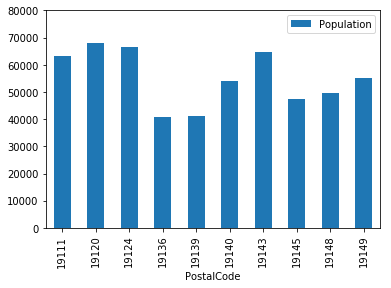

In [94]:
phil_nocoffee.PostalCode = phil_nocoffee.PostalCode.astype(int)
phil_nocoffee.Population = phil_nocoffee.Population.astype(int)

phil_nocoffee = phil_nocoffee[phil_nocoffee['Population'] > 40000]

phil_nocoffee.plot(x='PostalCode', y='Population', kind='bar', ylim=[0,80000])

According to the data, we can see that the best place to put a new Starbucks in Philadelphia would be the zip code 19120. It has the highest amount of population than the compared zip codes and where coffee shops do not represent it's most common venues. 